In [71]:
# Resource: https://stackabuse.com/association-rule-mining-via-apriori-algorithm-in-python

## Import packages

In [72]:
import pandas as pd
import nltk
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## Import data

In [73]:
df = pd.read_json('goodreads_reviews_children.json', lines = True)

## Prepare Data

1. Filter for Reviews of Top 10 Books
2. Group review_text by book
3. Filter for sentences that contain aspects

### Filter for Top 10 Books

In [74]:
book_selection = df.groupby('book_id').size().reset_index()
book_selection = book_selection.rename(columns = {0:'value_count'}).sort_values('value_count', ascending = False)
print(book_selection.head(30))
book_selection = book_selection['book_id'][:10]

         book_id  value_count
88          3636         6156
0              5         4696
74564   11387515         4499
4678      157993         3114
2403       78411         1999
70142    9673436         1947
323         8127         1721
9794      370493         1697
75083   11594337         1575
54          2998         1524
1341       38709         1450
818        24178         1449
1399       39988         1387
104579  23302416         1351
10257     389627         1320
89750   17349203         1288
6662      236093         1184
14           378         1115
43          2839         1065
2562       83369         1058
1658       47281          974
480        13023          960
831        24213          940
1247       37186          923
1055       30119          915
190         6319          908
106992  24612624          907
1251       37190          899
695        19543          893
86257   16052012          869


In [75]:
df = df[df['book_id'].isin(book_selection)]
df

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
46,7b2e5fe9fd353fecf3eeebb4850b88d3,11594337,0cef00e7ac5b37c459c94083475413f7,5,"great story, heartwarming and very current wit...",Sat Jan 05 17:30:28 -0800 2013,Sun Jan 27 19:35:53 -0800 2013,,,0,0
54,0ef32090550901ead25cb0ea21c4d36b,157993,f379671d83939b72314ef2439d44e372,4,I read this in French during high school (Fren...,Wed Nov 21 16:45:09 -0800 2012,Wed Nov 21 16:45:46 -0800 2012,,,0,0
63,d37b46b2190ed7c518259f29b47a9b36,3636,ac7aae56c65adfde94bb8a9e653f67d3,5,A quick but engrossing dystopian novel. The re...,Thu Mar 30 11:33:22 -0700 2017,Thu Mar 30 18:10:44 -0700 2017,Thu Mar 30 00:00:00 -0700 2017,Wed Mar 29 00:00:00 -0700 2017,4,0
70,f4c6fe33ef61c38f7f4aeb5224c259a5,11387515,13f03d0906f27f5202865787efdf1bbc,4,I love how simple the story was told but the m...,Sun Nov 04 00:40:58 -0700 2012,Mon Nov 12 04:14:02 -0800 2012,Mon Nov 12 04:14:02 -0800 2012,Sun Nov 04 00:00:00 -0700 2012,0,0
71,f4c6fe33ef61c38f7f4aeb5224c259a5,157993,45c234cd783da040e9da8c3e81df0297,5,We should see with our hearts not with our eye...,Fri Nov 02 07:37:50 -0700 2012,Fri Apr 26 06:56:47 -0700 2013,,,1,0
...,...,...,...,...,...,...,...,...,...,...,...
734590,8970fe60796274ca4b58eeabfe6fb78e,5,a6a0628171a2dea1c09f87032ffb02d8,5,Love the books,Thu Nov 24 02:51:32 -0800 2016,Thu Nov 24 02:52:39 -0800 2016,Fri Jan 01 00:00:00 -0800 2016,Fri Jan 01 00:00:00 -0800 2016,0,0
734606,31a2c453c1742edd9732dff77ffc8a50,11387515,a5761512de5a6f1af1b60065e88924c6,5,Awesome book about the imperfections of humani...,Fri Mar 30 07:42:41 -0700 2012,Fri Mar 30 07:47:29 -0700 2012,Tue Mar 27 00:00:00 -0700 2012,,0,0
734613,ce27420f5dbfcecc92057a4000345027,2998,261b1729ad5c4331ca5ea490f4a0dea0,3,I was great to read an old classic that i reme...,Thu May 31 12:00:25 -0700 2012,Thu May 31 12:01:19 -0700 2012,,,0,0
734624,354ffdcbf956c820137b85bf8b957b9e,157993,84f15a500176f5c26d799614001bcc75,4,It's quite difficult for a layman like me to r...,Sat Jun 02 11:21:30 -0700 2012,Tue Jun 05 11:44:33 -0700 2012,Mon Jun 04 00:00:00 -0700 2012,Sat Jun 02 00:00:00 -0700 2012,0,0


### Group review_text by book

In [76]:
# This joins all the review_text for each book.
df_grouped = df.groupby(['book_id'])['review_text'].apply(' '.join).reset_index()
df_grouped

,book_id,review_text
0,5,This one definitely wasn't as good as the seco...
1,2998,One of my favorite books of all time. It is no...
2,3636,A quick but engrossing dystopian novel. The re...
3,8127,SO good! Can't wait to read the rest. This ran...
4,78411,An excellent read for bedtime--much better tha...
5,157993,I read this in French during high school (Fren...
6,370493,Makes me weepy every time I read it. Aside fro...
7,9673436,Great kid's book. Loved the pictures too My th...
8,11387515,I love how simple the story was told but the m...
9,11594337,"great story, heartwarming and very current wit..."


In [77]:
# This maps nltk sent_tokenize to review_text.
df_grouped['review_text'] = df_grouped['review_text'].map(nltk.sent_tokenize)
df_grouped['n_sentences'] = df_grouped['review_text'].map(len)
df_grouped

,book_id,review_text,n_sentences
0,5,[This one definitely wasn't as good as the sec...,17967
1,2998,"[One of my favorite books of all time., It is ...",6403
2,3636,"[A quick but engrossing dystopian novel., The ...",32310
3,8127,"[SO good!, Can't wait to read the rest., This ...",7827
4,78411,[An excellent read for bedtime--much better th...,9195
5,157993,[I read this in French during high school (Fre...,13243
6,370493,"[Makes me weepy every time I read it., Aside f...",5677
7,9673436,"[Great kid's book., Loved the pictures too My ...",10101
8,11387515,[I love how simple the story was told but the ...,26939
9,11594337,"[great story, heartwarming and very current wi...",8752


### Filter for sentences that contain aspects

In [78]:
aspect_list = ["story", "character", "message", "plot", "style", "writing", "point"]

In [79]:
# This function checks if a sentence contains a reference to an aspect. If so, keep the sentence.
def filter_list(review_text):
    
    lemmatizer = WordNetLemmatizer()

    new_review_text = []
    
    for sentence in review_text:
        # Word tokenize each sentence so we can iterate through it and lemmatize.
        sentence_tokens = word_tokenize(sentence)
        for word in sentence_tokens:
            # Lemmatize each word in the sentence and check if it is an aspect.
            if lemmatizer.lemmatize(word) in aspect_list and sentence not in new_review_text:
                new_review_text.append(sentence)
                
    return new_review_text

In [80]:
df_grouped['review_text_w_features'] = df_grouped['review_text'].map(filter_list)
df_grouped['n_sentences_w_features'] = df_grouped['review_text_w_features'].map(len)
df_grouped

,book_id,review_text,n_sentences,review_text_w_features,n_sentences_w_features
0,5,[This one definitely wasn't as good as the sec...,17967,[Rowling's plots are getting tighter and tight...,2052
1,2998,"[One of my favorite books of all time., It is ...",6403,[Like in the story how Frances Hodgson Burnett...,947
2,3636,"[A quick but engrossing dystopian novel., The ...",32310,[I didn't quite buy into the memory transfer t...,3428
3,8127,"[SO good!, Can't wait to read the rest., This ...",7827,[Thanks to the sympathetic character of Anne S...,1012
4,78411,[An excellent read for bedtime--much better th...,9195,[An excellent read for bedtime--much better th...,1278
5,157993,[I read this in French during high school (Fre...,13243,[The characters obviously were too one-dimensi...,1217
6,370493,"[Makes me weepy every time I read it., Aside f...",5677,"[While reading this book, I was thinking of th...",798
7,9673436,"[Great kid's book., Loved the pictures too My ...",10101,[The plot is entertaining- full of troubles an...,2376
8,11387515,[I love how simple the story was told but the ...,26939,[I love how simple the story was told but the ...,4639
9,11594337,"[great story, heartwarming and very current wi...",8752,"[great story, heartwarming and very current wi...",1622


## Using SpaCy for Pattern Matching

### Dependency Parser

In [81]:
import spacy
from spacy import displacy
from spacy.matcher import Matcher
from spacy.matcher import DependencyMatcher
from nltk.corpus import stopwords

In [82]:
stop_list = stopwords.words('english')
nlp = spacy.load("en_core_web_lg")

In [83]:
# The story was interesting.
pattern1 = [
    {
        "RIGHT_ID": "aspect",
        "RIGHT_ATTRS": {"LEMMA": {"IN": aspect_list}}
    },
    {
        "LEFT_ID": "aspect",
        "REL_OP": "<",
        "RIGHT_ID": "aux",
        "RIGHT_ATTRS": {"lemma": "be"}
    },
    {
        "LEFT_ID": "aux",
        "REL_OP": ">",
        "RIGHT_ID": "opinion",
        "RIGHT_ATTRS": {"DEP": {"IN":["acomp", "amod"]}}
    }
]

# Fantastic story!
pattern2 = [
    {
        "RIGHT_ID": "aspect",
        "RIGHT_ATTRS": {"LEMMA": {"IN": aspect_list}}
    },
    {
        "LEFT_ID": "aspect",
        "REL_OP": ">",
        "RIGHT_ID": "opinion",
        "RIGHT_ATTRS": {"DEP": {"IN":["acomp", "amod"]}}
    }
]

# The plot is genius.
pattern3 = [
    {
        "RIGHT_ID": "aspect",
        "RIGHT_ATTRS": {"LEMMA": {"IN": aspect_list}}
    },
    {
        "LEFT_ID": "aspect",
        "REL_OP": "<",
        "RIGHT_ID": "aux",
        "RIGHT_ATTRS": {"lemma": "be"}
    },
    {
        "LEFT_ID": "aux",
        "REL_OP": ">",
        "RIGHT_ID": "opinion",
        "RIGHT_ATTRS": {"DEP": "attr"}
    }
]

# I like this story.
pattern4 = [
    {
        "RIGHT_ID": "aspect",
        "RIGHT_ATTRS": {"LEMMA": {"IN": aspect_list}}
    },
    {
        "LEFT_ID": "aspect",
        "REL_OP": "<",
        "RIGHT_ID": "opinion",
        "RIGHT_ATTRS": {"LEMMA": {"IN":["like", "love", "enjoy",
                                        "dislike", "hate"]}}
#         "RIGHT_ATTRS": {"POS": {"IN":["ADJ", "VERB"]}}
    }
]

# There is something so enchanting about these stories.
pattern5 = [
    {
        "RIGHT_ID": "aspect",
        "RIGHT_ATTRS": {"LEMMA": {"IN": aspect_list}}
    },
    {
        "LEFT_ID": "aspect",
        "REL_OP": "<<",
        "RIGHT_ID": "opinion",
        "RIGHT_ATTRS": {"DEP": {"IN":["acomp", "amod"]}}
    }
]

pattern6 = [
    {
        "RIGHT_ID": "aspect",
        "RIGHT_ATTRS": {"LEMMA": {"IN": aspect_list}}
    },
    {
        "LEFT_ID": "aspect",
        "REL_OP": "<<",
        "RIGHT_ID": "root",
        "RIGHT_ATTRS": {"DEP": "ROOT"}
    },
    {
        "LEFT_ID": "root",
        "REL_OP": ">>",
        "RIGHT_ID": "opinion",
        "RIGHT_ATTRS": {"DEP": {"IN":["acomp", "amod"]}}
    }
]

In [84]:
def dependency_matcher_helper(doc, pattern, aspect_sentiments):
    
    matcher = DependencyMatcher(nlp.vocab)
    matcher.add("pattern", [pattern])

    doc = nlp(doc)
    matches = matcher(doc)
    
    try:
        new_dict = {}

        match_id, token_ids = matches[0]
        for i in range(len(token_ids)):
            
            if pattern[i]["RIGHT_ID"] == "aspect":
                new_dict['aspect'] = doc[token_ids[i]].text
            elif pattern[i]["RIGHT_ID"] == "opinion" and doc[token_ids[i]].text not in stop_list:
                new_dict["opinion"] = doc[token_ids[i]].text
            
            if len(new_dict) == 2:
                aspect_sentiments.append(new_dict)
                
                return True
        
        return False
        
    except:
        return False

In [85]:
def dependency_matcher_helper_helper(doc, aspect_sentiments):
    
    if dependency_matcher_helper(doc, pattern1, aspect_sentiments):
        return True
    elif dependency_matcher_helper(doc, pattern2, aspect_sentiments):
        return True
    elif dependency_matcher_helper(doc, pattern3, aspect_sentiments):
        return True
    elif dependency_matcher_helper(doc, pattern4, aspect_sentiments):
        return True
    elif dependency_matcher_helper(doc, pattern5, aspect_sentiments):
        return True
    elif dependency_matcher_helper(doc, pattern6, aspect_sentiments):
        return True

In [86]:
def dependency_matcher(review_text_with_features):
    
    aspect_sentiments = []

    for sentence in review_text_with_features:
        dependency_matcher_helper_helper(sentence, aspect_sentiments)
    return aspect_sentiments

In [87]:
df_grouped['aspect_sentiment'] = df_grouped['review_text_w_features'].map(dependency_matcher)
df_grouped['n_aspects_sentiments'] = df_grouped['aspect_sentiment'].map(len)
df_grouped

,book_id,review_text,n_sentences,review_text_w_features,n_sentences_w_features,aspect_sentiment,n_aspects_sentiments
0,5,[This one definitely wasn't as good as the sec...,17967,[Rowling's plots are getting tighter and tight...,2052,"[{'aspect': 'plots', 'opinion': 'tighter'}, {'...",1636
1,2998,"[One of my favorite books of all time., It is ...",6403,[Like in the story how Frances Hodgson Burnett...,947,"[{'aspect': 'story', 'opinion': 'familiar'}, {...",783
2,3636,"[A quick but engrossing dystopian novel., The ...",32310,[I didn't quite buy into the memory transfer t...,3428,"[{'aspect': 'story', 'opinion': 'little'}, {'a...",2724
3,8127,"[SO good!, Can't wait to read the rest., This ...",7827,[Thanks to the sympathetic character of Anne S...,1012,"[{'aspect': 'character', 'opinion': 'sympathet...",845
4,78411,[An excellent read for bedtime--much better th...,9195,[An excellent read for bedtime--much better th...,1278,"[{'aspect': 'story', 'opinion': 'interesting'}...",1057
5,157993,[I read this in French during high school (Fre...,13243,[The characters obviously were too one-dimensi...,1217,"[{'aspect': 'characters', 'opinion': 'dimensio...",986
6,370493,"[Makes me weepy every time I read it., Aside f...",5677,"[While reading this book, I was thinking of th...",798,"[{'aspect': 'story', 'opinion': 'short'}, {'as...",629
7,9673436,"[Great kid's book., Loved the pictures too My ...",10101,[The plot is entertaining- full of troubles an...,2376,"[{'aspect': 'plot', 'opinion': 'entertaining-'...",1916
8,11387515,[I love how simple the story was told but the ...,26939,[I love how simple the story was told but the ...,4639,"[{'aspect': 'story', 'opinion': 'simple'}, {'a...",3789
9,11594337,"[great story, heartwarming and very current wi...",8752,"[great story, heartwarming and very current wi...",1622,"[{'aspect': 'story', 'opinion': 'great'}, {'as...",1346


## Using Textblob to determine sentiment

In [88]:
from textblob import TextBlob

In [89]:
# This function applies TextBlob sentiment analysis to each opinion word.
def textblob_sentiment(aspect_sentiment):
    
    text_blob_analysis = []
    
    for aspect in aspect_sentiment:
        new_dict = {}
        
        new_dict['aspect'] = aspect['aspect']
        new_dict['opinion'] = aspect['opinion']
        new_dict['sentiment'] = TextBlob(aspect['opinion']).sentiment
        
        text_blob_analysis.append(new_dict)
        
    return text_blob_analysis

In [90]:
df_grouped['text_blob_results'] = df_grouped['aspect_sentiment'].map(textblob_sentiment)
df_grouped

,book_id,review_text,n_sentences,review_text_w_features,n_sentences_w_features,aspect_sentiment,n_aspects_sentiments,text_blob_results
0,5,[This one definitely wasn't as good as the sec...,17967,[Rowling's plots are getting tighter and tight...,2052,"[{'aspect': 'plots', 'opinion': 'tighter'}, {'...",1636,"[{'aspect': 'plots', 'opinion': 'tighter', 'se..."
1,2998,"[One of my favorite books of all time., It is ...",6403,[Like in the story how Frances Hodgson Burnett...,947,"[{'aspect': 'story', 'opinion': 'familiar'}, {...",783,"[{'aspect': 'story', 'opinion': 'familiar', 's..."
2,3636,"[A quick but engrossing dystopian novel., The ...",32310,[I didn't quite buy into the memory transfer t...,3428,"[{'aspect': 'story', 'opinion': 'little'}, {'a...",2724,"[{'aspect': 'story', 'opinion': 'little', 'sen..."
3,8127,"[SO good!, Can't wait to read the rest., This ...",7827,[Thanks to the sympathetic character of Anne S...,1012,"[{'aspect': 'character', 'opinion': 'sympathet...",845,"[{'aspect': 'character', 'opinion': 'sympathet..."
4,78411,[An excellent read for bedtime--much better th...,9195,[An excellent read for bedtime--much better th...,1278,"[{'aspect': 'story', 'opinion': 'interesting'}...",1057,"[{'aspect': 'story', 'opinion': 'interesting',..."
5,157993,[I read this in French during high school (Fre...,13243,[The characters obviously were too one-dimensi...,1217,"[{'aspect': 'characters', 'opinion': 'dimensio...",986,"[{'aspect': 'characters', 'opinion': 'dimensio..."
6,370493,"[Makes me weepy every time I read it., Aside f...",5677,"[While reading this book, I was thinking of th...",798,"[{'aspect': 'story', 'opinion': 'short'}, {'as...",629,"[{'aspect': 'story', 'opinion': 'short', 'sent..."
7,9673436,"[Great kid's book., Loved the pictures too My ...",10101,[The plot is entertaining- full of troubles an...,2376,"[{'aspect': 'plot', 'opinion': 'entertaining-'...",1916,"[{'aspect': 'plot', 'opinion': 'entertaining-'..."
8,11387515,[I love how simple the story was told but the ...,26939,[I love how simple the story was told but the ...,4639,"[{'aspect': 'story', 'opinion': 'simple'}, {'a...",3789,"[{'aspect': 'story', 'opinion': 'simple', 'sen..."
9,11594337,"[great story, heartwarming and very current wi...",8752,"[great story, heartwarming and very current wi...",1622,"[{'aspect': 'story', 'opinion': 'great'}, {'as...",1346,"[{'aspect': 'story', 'opinion': 'great', 'sent..."


## Vader

In [91]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [109]:
def vader_vs_textblob(word):
    print('Vader result for', word, analyzer.polarity_scores(word))
    print('Text Blob result for ', word, TextBlob(word).sentiment)

Running Vader and Textblob on some of the most commonly picked up opinion words, we find that Vader and Textblob are directionally similar with Textblob leaning slightly more positive.

In [110]:
vader_vs_textblob('great')
vader_vs_textblob('beautiful')
vader_vs_textblob('interesting')
vader_vs_textblob('main')
vader_vs_textblob('favorite')

Vader result for great {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249}
Vader result for beautiful {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5994}
Vader result for interesting {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4019}
Vader result for main {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Vader result for favorite {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4588}


In [94]:
# This function applies TextBlob sentiment analysis to each opinion word.
def vader_sentiment(aspect_sentiment):
    
    vader_analysis = []
    
    for aspect in aspect_sentiment:
        new_dict = {}
        
        new_dict['aspect'] = aspect['aspect']
        new_dict['opinion'] = aspect['opinion']
        new_dict['sentiment'] = analyzer.polarity_scores(aspect['opinion'])
        
        vader_analysis.append(new_dict)
        
    return vader_analysis

In [95]:
df_grouped['vader_results'] = df_grouped['aspect_sentiment'].map(vader_sentiment)
df_grouped

,book_id,review_text,n_sentences,review_text_w_features,n_sentences_w_features,aspect_sentiment,n_aspects_sentiments,text_blob_results,vader_results
0,5,[This one definitely wasn't as good as the sec...,17967,[Rowling's plots are getting tighter and tight...,2052,"[{'aspect': 'plots', 'opinion': 'tighter'}, {'...",1636,"[{'aspect': 'plots', 'opinion': 'tighter', 'se...","[{'aspect': 'plots', 'opinion': 'tighter', 'se..."
1,2998,"[One of my favorite books of all time., It is ...",6403,[Like in the story how Frances Hodgson Burnett...,947,"[{'aspect': 'story', 'opinion': 'familiar'}, {...",783,"[{'aspect': 'story', 'opinion': 'familiar', 's...","[{'aspect': 'story', 'opinion': 'familiar', 's..."
2,3636,"[A quick but engrossing dystopian novel., The ...",32310,[I didn't quite buy into the memory transfer t...,3428,"[{'aspect': 'story', 'opinion': 'little'}, {'a...",2724,"[{'aspect': 'story', 'opinion': 'little', 'sen...","[{'aspect': 'story', 'opinion': 'little', 'sen..."
3,8127,"[SO good!, Can't wait to read the rest., This ...",7827,[Thanks to the sympathetic character of Anne S...,1012,"[{'aspect': 'character', 'opinion': 'sympathet...",845,"[{'aspect': 'character', 'opinion': 'sympathet...","[{'aspect': 'character', 'opinion': 'sympathet..."
4,78411,[An excellent read for bedtime--much better th...,9195,[An excellent read for bedtime--much better th...,1278,"[{'aspect': 'story', 'opinion': 'interesting'}...",1057,"[{'aspect': 'story', 'opinion': 'interesting',...","[{'aspect': 'story', 'opinion': 'interesting',..."
5,157993,[I read this in French during high school (Fre...,13243,[The characters obviously were too one-dimensi...,1217,"[{'aspect': 'characters', 'opinion': 'dimensio...",986,"[{'aspect': 'characters', 'opinion': 'dimensio...","[{'aspect': 'characters', 'opinion': 'dimensio..."
6,370493,"[Makes me weepy every time I read it., Aside f...",5677,"[While reading this book, I was thinking of th...",798,"[{'aspect': 'story', 'opinion': 'short'}, {'as...",629,"[{'aspect': 'story', 'opinion': 'short', 'sent...","[{'aspect': 'story', 'opinion': 'short', 'sent..."
7,9673436,"[Great kid's book., Loved the pictures too My ...",10101,[The plot is entertaining- full of troubles an...,2376,"[{'aspect': 'plot', 'opinion': 'entertaining-'...",1916,"[{'aspect': 'plot', 'opinion': 'entertaining-'...","[{'aspect': 'plot', 'opinion': 'entertaining-'..."
8,11387515,[I love how simple the story was told but the ...,26939,[I love how simple the story was told but the ...,4639,"[{'aspect': 'story', 'opinion': 'simple'}, {'a...",3789,"[{'aspect': 'story', 'opinion': 'simple', 'sen...","[{'aspect': 'story', 'opinion': 'simple', 'sen..."
9,11594337,"[great story, heartwarming and very current wi...",8752,"[great story, heartwarming and very current wi...",1622,"[{'aspect': 'story', 'opinion': 'great'}, {'as...",1346,"[{'aspect': 'story', 'opinion': 'great', 'sent...","[{'aspect': 'story', 'opinion': 'great', 'sent..."


## Visualizations

In [96]:
import matplotlib.pyplot as plt

In [97]:
def summarize_text_blob_results(text_blob_results):
    
    df = pd.DataFrame(text_blob_results)
    
    df[['polarity', 'subjectivity']] = pd.DataFrame(pd.DataFrame(df['sentiment'].tolist()), index = df.index)
    
    df = df.groupby(['aspect']).agg({'aspect': 'size', 'polarity': 'mean', 'subjectivity':'mean'})

    df = df.rename(columns={'aspect':'count'}).sort_values('count', ascending = False)
    
    return df

In [98]:
def summarize_vader_results(vader_results):
    
    df = pd.DataFrame(vader_results)
    
    df[['neg', 'neu', 'pos', 'compound']] = pd.DataFrame(pd.DataFrame(df['sentiment'].tolist()), index = df.index)
    
    df = df.groupby(['aspect']).agg({'aspect': 'size', 'compound': 'mean'})

    df = df.rename(columns={'aspect':'count'}).sort_values('count', ascending = False)
    
    return df

In [99]:
summarize_vader_results(df_grouped['vader_results'][7])[:10]

,count,compound
aspect,,
story,1386,0.251826
characters,128,0.172366
plot,99,0.183473
character,79,0.125580
writing,70,0.212336
style,49,0.172747
message,47,0.098340
stories,31,0.138387
point,17,0.187953


### Book id 9673436

<AxesSubplot:title={'center':'The Invention of Hugo Cabret'}, xlabel='Aspects', ylabel='Count'>

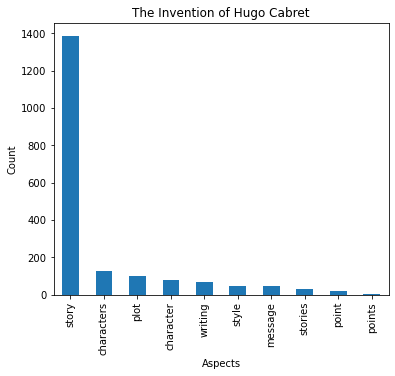

In [100]:
df_9673436 = df_grouped['aspect_sentiment'][7]
df_9673436 = pd.DataFrame(df_9673436)
df_9673436 = df_9673436.groupby(['aspect']).size().sort_values(ascending = False)[:10]
df_9673436.plot(kind='bar', title='The Invention of Hugo Cabret', ylabel='Count',
         xlabel='Aspects', figsize=(6, 5))

<AxesSubplot:title={'center':'The Invention of Hugo Cabret'}, xlabel='Sentiment', ylabel='Count'>

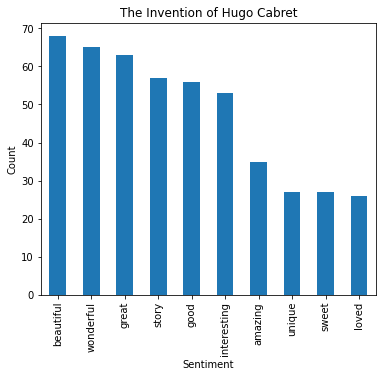

In [101]:
df_9673436 = df_grouped['aspect_sentiment'][7]
df_9673436 = pd.DataFrame(df_9673436)
df_9673436 = df_9673436.groupby(['opinion']).size().sort_values(ascending = False)[:10]
df_9673436.plot(kind='bar', title='The Invention of Hugo Cabret', ylabel='Count',
         xlabel='Sentiment', figsize=(6, 5))

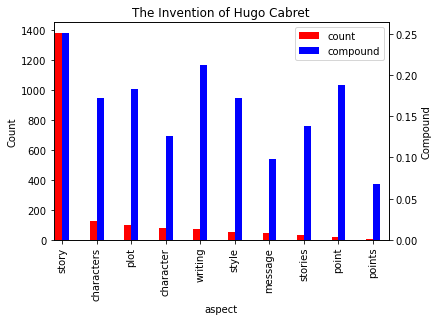

In [108]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.2

df_9673436 = summarize_vader_results(df_grouped['vader_results'][7])[:10]
df_9673436['count'].plot(kind='bar', color='red', ax=ax, width=width, position=1)
df_9673436['compound'].plot(kind='bar', color='blue', ax=ax2, width=width, position=0,
                           title = 'The Invention of Hugo Cabret')

ax.set_ylabel('Count')
ax2.set_ylabel('Compound')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

## Evaluation

In [103]:
def aspect_extract_eval(sentences):
    n_sentences = len(sentences)
    aspects = dependency_matcher(sentences)
    n_aspects = len(aspects)
    pct_aspects = n_aspects / n_sentences * 100
    
    print(pct_aspects, "% aspects and sentiments extracted")
    
    return aspects

### Book id 5

In [104]:
sent_eval = df_grouped['review_text_w_features'][0][:5]
sent_eval

["Rowling's plots are getting tighter and tighter and this one is no exception with great surprises in the last chapters.",
 'It introduces Sirius Black and Remus Lupin who are some of my favorite characters.',
 "The story keeps getting better and better, and one can't help but be happy to enter that world once again and keep fighting the dark wizard!",
 "I know it would hurt the plot a lot, but I think Rowling shouldn't have made something so powerful.",
 'His tenderness is apparent, in the fact that unlike most of the characters, he never "shouts," only patiently inquires.']

In [105]:
aspects = aspect_extract_eval(sent_eval)
aspects

100.0 % aspects and sentiments extracted


[{'aspect': 'plots', 'opinion': 'tighter'},
 {'aspect': 'characters', 'opinion': 'favorite'},
 {'aspect': 'story', 'opinion': 'better'},
 {'aspect': 'plot', 'opinion': 'powerful'},
 {'aspect': 'characters', 'opinion': 'apparent'}]

1/5 extracted correctly.

Correctly extracts characters and favorite from: 'It introduces Sirius Black and Remus Lupin who are some of my favorite characters.'.

For the other sentences, the sentiment is incorrect. For sentences 4 and 5, nothing should have been extracted as there's no clear sentiment expressed about the aspect.

In [106]:
vader_sentiment(aspects)

[{'aspect': 'plots',
  'opinion': 'tighter',
  'sentiment': {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}},
 {'aspect': 'characters',
  'opinion': 'favorite',
  'sentiment': {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4588}},
 {'aspect': 'story',
  'opinion': 'better',
  'sentiment': {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4404}},
 {'aspect': 'plot',
  'opinion': 'powerful',
  'sentiment': {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4215}},
 {'aspect': 'characters',
  'opinion': 'apparent',
  'sentiment': {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}}]

# Analysis

In [107]:
summarize_vader_results(df_grouped['vader_results'][0])[:10]

,count,compound
aspect,,
characters,481,0.224791
story,424,0.199531
plot,235,0.129003
character,231,0.240142
point,93,0.041066
writing,76,0.270408
stories,46,0.147526
points,15,0.172280
style,15,0.220307
